In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import random
from glob import glob
import cv2
from tqdm import tqdm
import time

import csv
from skimage import io
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [2]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu') 

In [3]:
path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

In [4]:
paths_mask= glob(f'{path}/*/*_mask*')
paths_imgs= [x.replace('_mask', '') for x in paths_mask]

In [5]:
brain_df= pd.DataFrame({'images': paths_imgs, 'masks':  paths_mask,})
brain_df.head()

,images,masks
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  3929 non-null   object
 1   masks   3929 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB


In [7]:
brain_df.isnull().sum()

images    0
masks     0
dtype: int64

In [8]:
brain_df['images'].value_counts()

images
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_38.tif    1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif    1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif     1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif    1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif    1
                                                                                                  ..
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_49.tif    1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_55.tif    1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_21.tif    1
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_1986

mask 1 found in : 2354


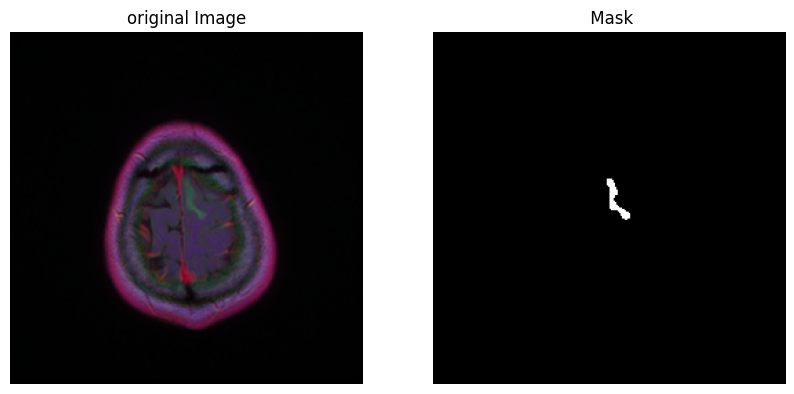

In [9]:
valid_index = []
for i in brain_df.index:
    masks = cv2.imread(brain_df.masks[i])
    masks_sum = np.sum(masks)
    if masks_sum > 32:
        valid_index.append(i)

i = random.choice( valid_index )
print("mask 1 found in :", i)
image = cv2.imread(brain_df.images[i])
mask = cv2.imread(brain_df.masks[i])

fig,axes = plt.subplots(1,2 ,figsize = (10,5))

axes[0].imshow(image)
axes[0].set_title('original Image')
axes[0].axis("off")

axes[1].imshow(mask)
axes[1].set_title(' Mask')
axes[1].axis("off")

plt.show()

In [10]:
print("Image shape:",image.shape)
print("Mask shape:",mask.shape)

Image shape: (256, 256, 3)
Mask shape: (256, 256, 3)


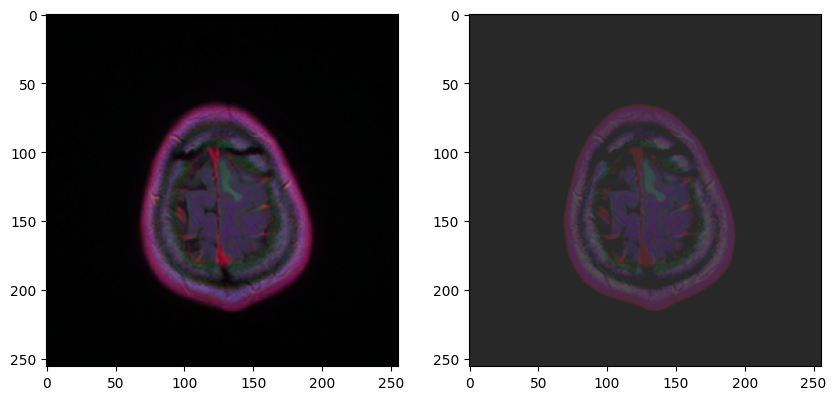

In [11]:
win_img = np.clip(image, 40,80)
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(image, cmap = 'gray')
axes[1].imshow(win_img, cmap = 'gray')
plt.show()

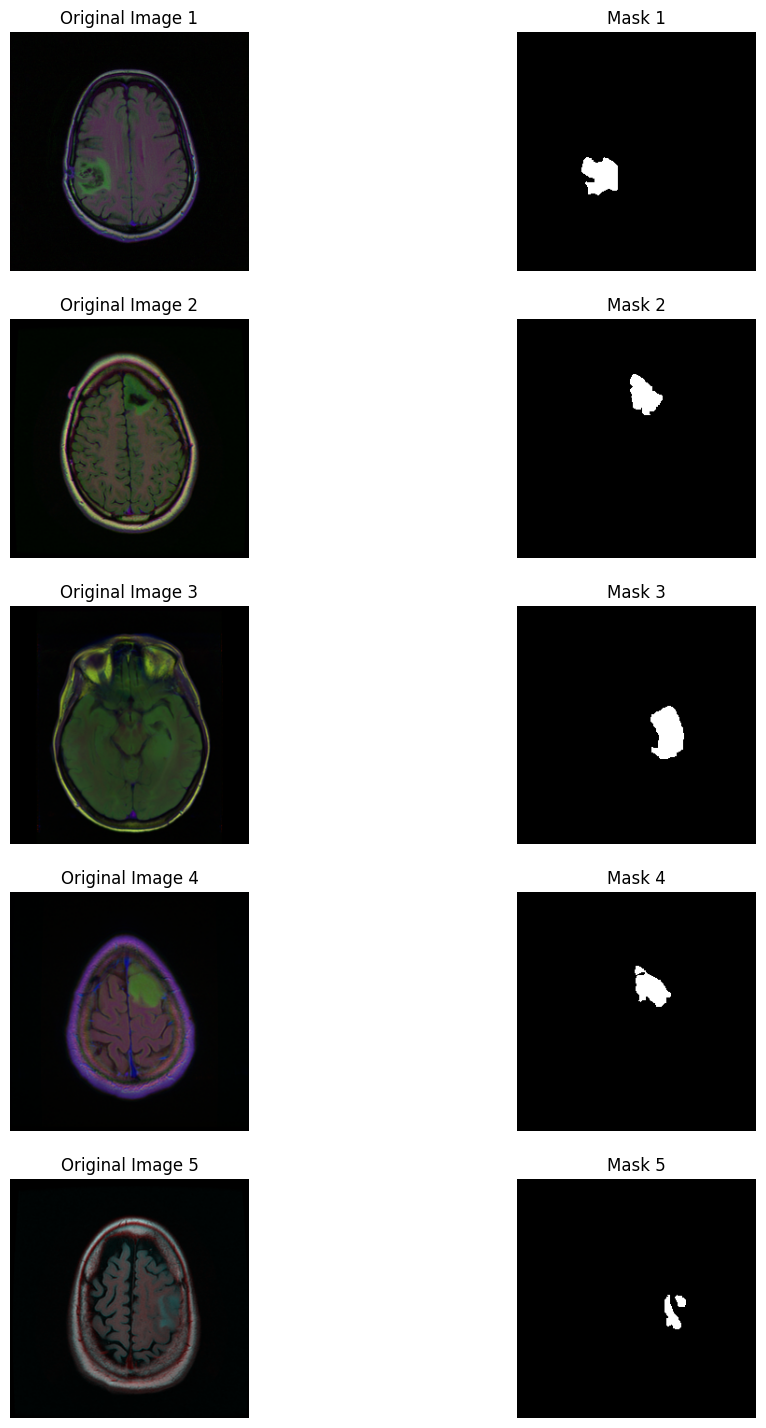

In [12]:
valid_index = []
for j in brain_df.index:
    masks = cv2.imread(brain_df.masks[j])
    masks_sum = np.sum(masks)
    if masks_sum > 32:
        valid_index.append(j)

fig,axes = plt.subplots(5,2 ,figsize = (12,18))
for i in range(5):
    
    index = random.choice( valid_index )
    
    image = cv2.imread(brain_df.images[index])
    mask = cv2.imread(brain_df.masks[index])
    
    
    axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis("off")

   
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis("off")
    
plt.show()

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),  
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [14]:
class BrainTumorSeg(Dataset):
    def __init__(self, images_paths, labels_paths):
        self.images_paths = images_paths
        self.labels_paths = labels_paths

    def __len__(self):
        return len(self.labels_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.images_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))  
        image = transform(image)  

        label = cv2.imread(self.labels_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, (256, 256)) 
        label = label.astype(np.float32) / 255.0 
        label = torch.tensor(label).unsqueeze(0)  

        return image.to(device), label.to(device)

In [15]:
train_df, rest = train_test_split(brain_df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(rest, test_size=0.3, random_state=42)

print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")

Train: 2750 | Validation: 354 | Test: 825


In [16]:
train_df.head()

,images,masks
1089,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2697,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1954,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3081,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1972,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [17]:
X_train, Y_train = train_df['images'].tolist(), train_df['masks'].tolist()
X_valid, Y_valid = valid_df['images'].tolist(), valid_df['masks'].tolist()
X_test, Y_test   = test_df['images'].tolist(), test_df['masks'].tolist()

In [18]:
train_dataset = BrainTumorSeg(X_train, Y_train)
valid_dataset = BrainTumorSeg(X_valid, Y_valid)
test_dataset  = BrainTumorSeg(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1)

In [19]:
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}") 
    print(f"Mask batch shape: {masks.shape}")  
    break 

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])


In [20]:
class double_convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_convolution, self).__init__()
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
        return x

In [21]:
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        return x

In [22]:
class downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(downsample_block, self).__init__()
        self.Downconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            double_convolution(in_channels, out_channels)
         )
    def forward(self, x):
        x = self.Downconv(x)
        return x

In [23]:
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [24]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [25]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64)
        self.down1 = downsample_block(64, 128)
        self.down2 = downsample_block(128, 256)
        self.down3 = downsample_block(256, 512)
        self.down4 = downsample_block(512, 512)
        self.up1 = upsample_block(1024, 256)
        self.up2 = upsample_block(512, 128)
        self.up3 = upsample_block(256, 64)
        self.up4 = upsample_block(128, 64)
        self.outc = OutConv(64, num_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.to(device);

In [27]:
# Define our learning rate, loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 15

In [28]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn):
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')
    model.eval()
    return history

In [29]:
history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn)

100%|██████████| 172/172 [01:42<00:00,  1.68it/s]


Epoch: 1/15 | Training loss: 0.1323540437221527 | Validation loss: 0.058169562095976145


100%|██████████| 172/172 [01:10<00:00,  2.45it/s]


Epoch: 2/15 | Training loss: 0.04764417682723566 | Validation loss: 0.049399892699583774


100%|██████████| 172/172 [01:09<00:00,  2.47it/s]


Epoch: 3/15 | Training loss: 0.04200486345995556 | Validation loss: 0.04417157255239406


100%|██████████| 172/172 [01:10<00:00,  2.46it/s]


Epoch: 4/15 | Training loss: 0.03942457842962308 | Validation loss: 0.041616694370316246


100%|██████████| 172/172 [01:10<00:00,  2.46it/s]


Epoch: 5/15 | Training loss: 0.037447247407653116 | Validation loss: 0.038198711760973524


100%|██████████| 172/172 [01:09<00:00,  2.47it/s]


Epoch: 6/15 | Training loss: 0.035897713149135764 | Validation loss: 0.04529376416388205


100%|██████████| 172/172 [01:09<00:00,  2.46it/s]


Epoch: 7/15 | Training loss: 0.035521725599738686 | Validation loss: 0.038493408637363356


100%|██████████| 172/172 [01:10<00:00,  2.46it/s]


Epoch: 8/15 | Training loss: 0.034413320032033054 | Validation loss: 0.03762552685151666


100%|██████████| 172/172 [01:11<00:00,  2.42it/s]


Epoch: 9/15 | Training loss: 0.033349134418097406 | Validation loss: 0.03795216254768946


100%|██████████| 172/172 [01:10<00:00,  2.44it/s]


Epoch: 10/15 | Training loss: 0.033496269345283505 | Validation loss: 0.03775927267631905


100%|██████████| 172/172 [01:11<00:00,  2.41it/s]


Epoch: 11/15 | Training loss: 0.033061183405193414 | Validation loss: 0.036532422832850006


100%|██████████| 172/172 [01:10<00:00,  2.44it/s]


Epoch: 12/15 | Training loss: 0.0326291260312904 | Validation loss: 0.044329780539350404


100%|██████████| 172/172 [01:09<00:00,  2.47it/s]


Epoch: 13/15 | Training loss: 0.032714268917387185 | Validation loss: 0.03419596906540926


100%|██████████| 172/172 [01:09<00:00,  2.49it/s]


Epoch: 14/15 | Training loss: 0.0316691275537014 | Validation loss: 0.033870083243075735


100%|██████████| 172/172 [01:09<00:00,  2.47it/s]


Epoch: 15/15 | Training loss: 0.031031761636788197 | Validation loss: 0.033347692508987115


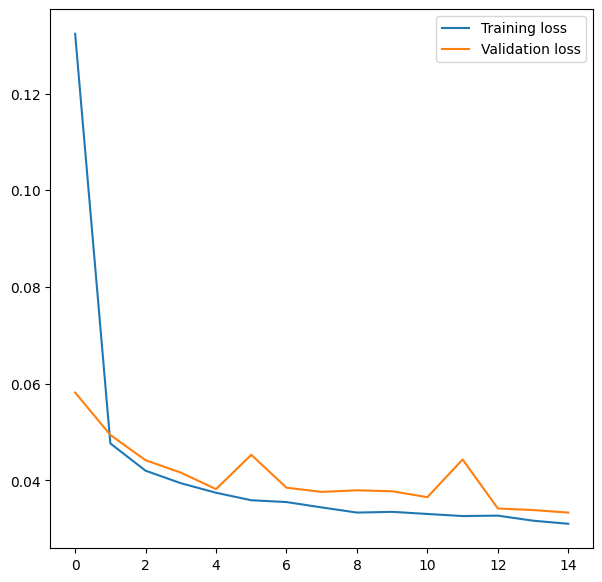

In [30]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [31]:
with torch.no_grad():
    running_loss = 0
    for i, data in enumerate(test_loader):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        predictions = model(img)
        loss = loss_fn(predictions, mask)
        running_loss += loss.item() * img.size(0)
    loss = running_loss / len(test_dataset)
    
    print(f'Tests: loss: {loss}')

Tests: loss: 0.033399884440728014


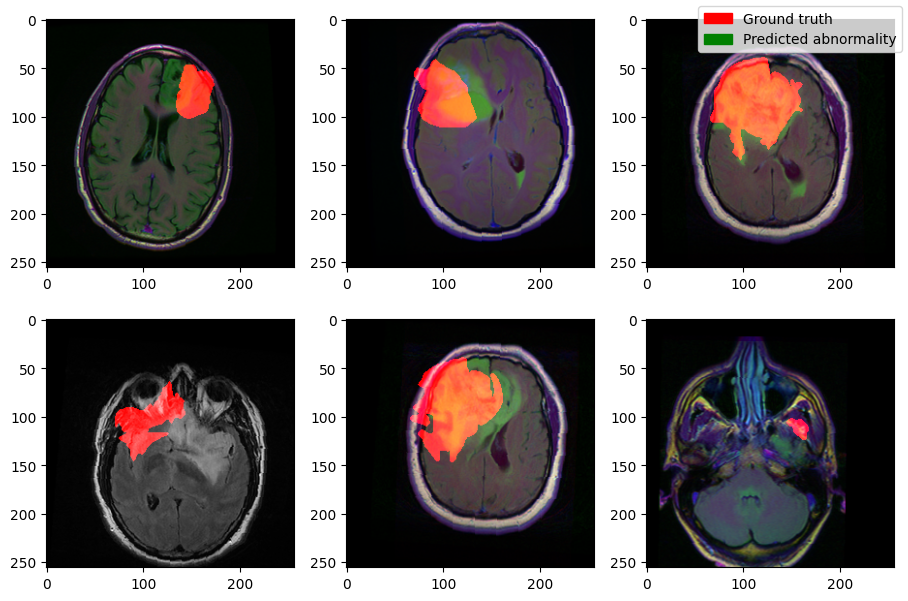

In [48]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.ndimage import binary_dilation

# Define figure size and layout
width = 3
columns = 2
n_examples = 6

fig, axs = plt.subplots(columns, width, figsize=(3 * width, 3 * columns), constrained_layout=True)
fig.legend(loc='upper right', handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')
])

i = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask.to(device)[0]  

        if not mask.byte().any():
            continue 

        image = image.to(device)
        prediction = model(image)[0][0] 

        
        prediction = (prediction > 0.5).float()

        
        prediction_edges = torch.tensor(binary_dilation(prediction.cpu().numpy()), device=device)
        ground_truth = torch.tensor(binary_dilation(mask.cpu().numpy()), device=device)

       
        img_np = image[0].cpu().numpy().transpose(1, 2, 0)  

       
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        img_np[..., 0] = np.maximum(img_np[..., 0], ground_truth.cpu().numpy()) 
        img_np[..., 1] = np.maximum(img_np[..., 1], prediction_edges.cpu().numpy())  

        
        axs[i // width][i % width].imshow(img_np)

        if i + 1 == n_examples:
            break
        i += 1

plt.show()
